
# Gussow Well Placement Experiments 
### Michael Pyrcz, Associate Professor, University of Texas at Austin 
#### Contacts: [Twitter/@GeostatsGuy](https://twitter.com/geostatsguy) | [GitHub/GeostatsGuy](https://github.com/GeostatsGuy) | [www.michaelpyrcz.com](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446)

Workflow from the submitted paper (submitted end of November, 2018).  I have provided this workflow in the spirit of reproduceable research. 

o. Pyrcz, M., in press, Geostatistical Workflows for Modeling Uncertainty in Unconventional Reservoirs, Bulletin for Canadian Society of Petroleum Geologists.

#### About this Workbook

This Jupyter notebook includes the numerical experiments for resampling from EUR spatial distributions to assess uncertainty in and between sets of samples.  The method is completely general and could be applied to any spatially distributed feature, conditioning, trends and area of interest.

This workflow is in Python with wrappers and reimplimentation of GSLIB methods.  The steps include:

1. generate a 2D sequential Guassian simulation using a wrapper of GSLIB's sgsim method
2. apply resampling based on a well pad design
3. iterate over many realizations with 5 scenarios for variogram range
4. build a DataFrame with results, calculate the required conditional statistics and plot with MatPlotLib and also exported to a comma delimited 'csv' file for additional analysis.

To accomplish this I have provide wrappers or reimplementation in Python for the following GSLIB methods:

1. sgsim - sequantial Gaussian simulation limited to 2D and unconditional
2. hist - histograms plots reimplemented with GSLIB parameters using python methods
3. locmap - location maps reimplemented with GSLIB parameters using python methods
4. pixelplt - pixel plots reimplemented with GSLIB parameters using python methods
5. locpix - my modification of GSLIB to superimpose a location map on a pixel plot reimplemented with GSLIB parameters using Python methods
5. affine - affine correction adjust the mean and standard deviation of a feature reimplemented with GSLIB parameters using Python methods

These methods are all in the functions declared upfront. To run this demo please download and place in your working directory the following executables from the GSLIB/bin directory:

1. sgsim.exe

The GSLIB source and executables are available at http://www.statios.com/Quick/gslib.html.  For the reference on using GSLIB check out the User Guide, GSLIB: Geostatistical Software Library and User's Guide by Clayton V. Deutsch and Andre G. Journel.

I did this to allow people to use these GSLIB functions that are extremely robust in Python. Also this should be a bridge to allow so many familar with GSLIB to work in Python as a kept the parameterization and displays consistent with GSLIB.  The wrappers are simple functions declared below that write the parameter files, run the GSLIB executable in the working directory and load and visualize the output in Python. 

This file is included on GitHub for anyone to try it out https://github.com/GeostatsGuy/.  

#### Load the required libraries

The following code loads the required libraries.


In [2]:
import os                                                 # to set current working directory 
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames
import matplotlib
import matplotlib.pyplot as plt                           # plotting
import math
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
#from pylab import *

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare functions

Here are the wrappers and reimplementations of GSLIB method along with two utilities to load GSLIB's Geo-EAS from data files into DataFrames and 2D Numpy arrays.

In [3]:
# utility to convert GSLIB Geo-EAS files to a pandas DataFrame for use with Python methods

def GSLIB2Dataframe(data_file):
    import os
    import numpy as np  
    import pandas as pd

    colArray = []
    with open(data_file) as myfile:   # read first two lines
        head = [next(myfile) for x in range(2)]
        line2 = head[1].split()
        ncol = int(line2[0])
        for icol in range(0, ncol):
            head = [next(myfile) for x in range(1)]
            colArray.append(head[0].split()[0])
        data = np.loadtxt(myfile, skiprows = 0)
        df = pd.DataFrame(data)
        df.columns = colArray
        return df
    
# utility to convert GSLIB Geo-EAS files to a numpy ndarray for use with Python methods
def GSLIB2ndarray(data_file,kcol,nx,ny):
    import os
    import numpy as np  

    colArray = []
    array = np.ndarray(shape=(nx,ny),dtype=float,order='F')
    with open(data_file) as myfile:   # read first two lines
        head = [next(myfile) for x in range(2)]
        line2 = head[1].split()
        ncol = int(line2[0])          # get the number of columns
        for icol in range(0, ncol):   # read over the column names
            head = [next(myfile) for x in range(1)]
            if icol == kcol:
                col_name = head[0].split()[0]
        for iy in range(0,ny):
            for ix in range(0,nx):
                head = [next(myfile) for x in range(1)]
                array[ny-1-iy][ix] = head[0].split()[kcol]
    return array,col_name
    
# histogram, reimplemented in Python of GSLIB hist with MatPlotLib methods
def hist(array,xmin,xmax,log,cumul,bins,weights,xlabel,title,fig_name):
    plt.figure(figsize=(8,6))     
    cs = plt.hist(array, alpha = 0.2, color = 'red', edgecolor = 'black', bins=bins, range = [xmin,xmax], weights = weights, log = log, cumulative = cumul)
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel('Frequency') 
    plt.savefig(fig_name + '.tif',dpi=600)
    plt.show()
    return

def hist_st(array,xmin,xmax,log,cumul,bins,weights,xlabel,title,fig_name):  
    cs = plt.hist(array, alpha = 0.2, color = 'red', edgecolor = 'black', bins=bins, range = [xmin,xmax], weights = weights, log = log, cumulative = cumul)
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel('Frequency') 
    return
   
# pixelplt, reimplemention in Python of GSLIB pixelplt with MatPlotLib methods
def pixelplt(array,xmin,xmax,ymin,ymax,step,vmin,vmax,title,xlabel,ylabel,vlabel,cmap,fig_name):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    ixy = 0 
    plt.figure(figsize=(8,6))
    x = [];y = []; v = [] # use dummy since scatter plot controls legend min and max appropriately and contour does not!
    color_int = np.r_[np.log(vmin):np.log(vmax):0.5]
    color_int = np.exp(color_int)
    cs = plt.contourf(xx,yy,array,cmap=cmap,vmin=vmin,vmax=vmax,levels = color_int, norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax))
    im = plt.scatter(x,y,s=None, c=v, marker=None,cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black",norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    #plt.clim(vmin,vmax)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.savefig(fig_name + '.tif',dpi=600)
    plt.show()
    return plt

def pixelplt_st(array,xmin,xmax,ymin,ymax,step,vmin,vmax,title,xlabel,ylabel,vlabel,cmap,fig_name):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    ixy = 0 
    x = [];y = []; v = [] # use dummy since scatter plot controls legend min and max appropriately and contour does not!
    color_int = np.r_[np.log(vmin):np.log(vmax):0.5]
    color_int = np.exp(color_int)
    cs = plt.contourf(xx,yy,array,cmap=cmap,vmin=vmin,vmax=vmax,levels = color_int, norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax))
    im = plt.scatter(x,y,s=None, c=v, marker=None,cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black",norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    #plt.clim(vmin,vmax)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    return cs

# location map, reimplemention in Python of GSLIB locmap with MatPlotLib methods
def locmap(df,xcol,ycol,vcol,xmin,xmax,ymin,ymax,vmin,vmax,title,xlabel,ylabel,vlabel,cmap):
    ixy = 0 
    plt.figure(figsize=(8,6))    
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, norm=None, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.show()
    return im

# pixelplt with location map superimposed, reimplementation in Python of a MOD from GSLIB with MatPlotLib methods
def locpix(array,xmin,xmax,ymin,ymax,step,vmin,vmax,df,xcol,ycol,vcol,title,xlabel,ylabel,vlabel,cmap,fig_name):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    ixy = 0 
    plt.figure(figsize=(8,6))
    color_int = np.r_[np.log(vmin):np.log(vmax):0.5]
    color_int = np.exp(color_int)
    cs = plt.contourf(xx, yy, array, cmap=cmap,vmin=vmin, vmax=vmax,levels = color_int, norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax))
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black",norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(orientation = 'vertical')
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    plt.savefig(fig_name + '.tif',dpi=600)
    plt.show()
    return cs

def locpix_st(array,xmin,xmax,ymin,ymax,step,vmin,vmax,df,xcol,ycol,vcol,title,xlabel,ylabel,vlabel,cmap,fig_name):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    ixy = 0 
    color_int = np.r_[np.log(vmin):np.log(vmax):0.5]
    color_int = np.exp(color_int)
    cs = plt.contourf(xx, yy, array, cmap=cmap,vmin=vmin, vmax=vmax,levels = color_int, norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax))
    im = plt.scatter(df[xcol],df[ycol],s=None, c=df[vcol], marker=None, cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black",norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(orientation = 'vertical')
    cbar.set_label(vlabel, rotation=270, labelpad=20)
    return cs

# affine distribution correction reimplemented in Python with numpy methods 
def affine(array,tmean,tstdev):    
    if array.ndim != 2:
        Print("Error: must use a 2D array")
        return
    nx = array.shape[0]
    ny = array.shape[1]
    mean = np.average(array)
    stdev = np.std(array)
    for iy in range(0,ny):
        for ix in range(0,nx):
             array[ix,iy]= (tstdev/stdev)*(array[ix,iy] - mean) + tmean  
    return(array) 

# exponentiate distribution correction reimplemented in Python with numpy methods 
def exponentiate(array):    
    if array.ndim != 2:
        Print("Error: must use a 2D array")
        return
    nx = array.shape[0]
    ny = array.shape[1]
    for iy in range(0,ny):
        for ix in range(0,nx):
             array[ix,iy]= math.exp(array[ix,iy])  
    return(array) 
 
# sequential Gaussian simulation, 2D unconditional wrapper for sgsim from GSLIB (.exe must be in working directory)
def GSLIB_sgsim_2d_uncond(nreal,nx,ny,hsiz,seed,hrange1,hrange2,azi,output_file):
    import os
    import numpy as np 
    
    hmn = hsiz * 0.5   
    hctab = int(hrange1/hsiz)*2 + 1
    
    sim_array = np.random.rand(nx,ny)
  
    file = open("sgsim.par", "w")
    file.write("              Parameters for SGSIM                                         \n")
    file.write("              ********************                                         \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETER:                                                        \n")
    file.write("none                          -file with data                              \n")
    file.write("1  2  0  3  5  0              -  columns for X,Y,Z,vr,wt,sec.var.          \n")
    file.write("-1.0e21 1.0e21                -  trimming limits                           \n")
    file.write("0                             -transform the data (0=no, 1=yes)            \n")
    file.write("none.trn                      -  file for output trans table               \n")
    file.write("1                             -  consider ref. dist (0=no, 1=yes)          \n")
    file.write("none.dat                      -  file with ref. dist distribution          \n")
    file.write("1  0                          -  columns for vr and wt                     \n")
    file.write("-4.0    4.0                   -  zmin,zmax(tail extrapolation)             \n")
    file.write("1      -4.0                   -  lower tail option, parameter              \n")
    file.write("1       4.0                   -  upper tail option, parameter              \n")
    file.write("0                             -debugging level: 0,1,2,3                    \n")
    file.write("nonw.dbg                      -file for debugging output                   \n")
    file.write(str(output_file) + "           -file for simulation output                  \n")
    file.write(str(nreal) + "                 -number of realizations to generate          \n")
    file.write(str(nx) + " " + str(hmn) + " " + str(hsiz) + "                              \n")
    file.write(str(ny) + " " + str(hmn) + " " + str(hsiz) + "                              \n")
    file.write("1 0.0 1.0                     - nz zmn zsiz                                \n")
    file.write(str(seed) + "                  -random number seed                          \n")
    file.write("0     8                       -min and max original data for sim           \n")
    file.write("12                            -number of simulated nodes to use            \n")
    file.write("0                             -assign data to nodes (0=no, 1=yes)          \n")
    file.write("1     3                       -multiple grid search (0=no, 1=yes),num      \n")
    file.write("0                             -maximum data per octant (0=not used)        \n")
    file.write(str(hrange1) + " " + str(hrange2) + " 1.0 -maximum search  (hmax,hmin,vert) \n")
    file.write(str(azi) + "   0.0   0.0       -angles for search ellipsoid                 \n")
    file.write(str(hctab) + " " + str(hctab) + " 1 -size of covariance lookup table        \n")
    file.write("0     0.60   1.0              -ktype: 0=SK,1=OK,2=LVM,3=EXDR,4=COLC        \n")
    file.write("none.dat                      -  file with LVM, EXDR, or COLC variable     \n")
    file.write("4                             -  column for secondary variable             \n")
    file.write("1    0.0                      -nst, nugget effect                          \n")
    file.write("1    1.0 " + str(azi) + " 0.0 0.0 -it,cc,ang1,ang2,ang3                    \n")
    file.write(" " + str(hrange1) + " " + str(hrange2) + " 1.0 -a_hmax, a_hmin, a_vert     \n")
    file.close()

    os.system('sgsim.exe sgsim.par')       
    sim_array = GSLIB2ndarray(output_file,0,nx,ny)         
    return(sim_array)

# extract pad samples from a model   
def extract_pad_sample(array,xmin,xmax,ymin,ymax,step,ox,oy,xspace,yspace,nxwell,nywell,name):
    x = []; y = []; v = []; iix = 0; iiy = 0;
    ixspace = int(xspace / step)
    iyspace = int(yspace / step)
    iiy = 0
    for iy in range(0,iyspace*nywell+1):
        if iiy >= iyspace:
            iix = 0
            for ix in range(0,ixspace*nxwell+1):
                if iix >= ixspace:
                    cx = ox + ix; cy = oy + iy 
                    x.append(step*(float(cx)-0.5)); y.append(step*(float(cy)-0.5)); v.append(array[ny-cy+1,cx])
                    iix = 0; iiy = 0
                iix = iix + 1
        iiy = iiy + 1
    df = pd.DataFrame(np.c_[x,y,v],columns=['X', 'Y', name])
    return(df)
        

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time).  Also, in this case make sure to place the required (see above) GSLIB executables in this directory or a location identified in the environmental variable *Path*.


In [4]:
os.chdir("C:/Users/mpyrc/OneDrive - The University of Texas at Austin/Conferences/Gussow2018/Experiment")                                   # set the working directory

You will have to update the part in quotes with your own working directory and the format is different on a Mac (e.g. "~/PGE"). 

##### Make a 2D spatial model

The following are the basic parameters for the experiment.  This includes the number of cells in the 2D regular grid, the cell size (step) and the x and y min and max along with the color scheme.

Then we make a single realization of a Gausian distributed feature over the specified 2D grid and then apply affine correction and then exponentiation to ensure we have a reasonable mean and spread for our feature's distribution, Estimated Ultimiate Recovery (EUR) while retaining the log normal distribution.  Any transform could be applied at this point.  We are keeping this workflow simple. *This is our truth model that we will sample*.

The parameters of *GSLIB_sgsim_2d_uncond* are (nreal,nx,ny,hsiz,seed,hrange1,hrange2,azi,output_file).  nreal is the number of realizations, nx and ny are the number of cells in x and y, hsiz is the cell siz, seed is the random number seed, hrange and hrange2 are the variogram ranges in major and minor directions respectively, azi is the azimuth of the primary direction of continuity (0 is aligned with Y axis) and output_file is a GEO_DAS file with the simulated realization.  The ouput is the 2D numpy array of the simulation along with the name of the property.

In [4]:
nx = 100; ny = 100; cell_size = 100                               # grid number of cells and cell size
xmin = 0.0; ymin = 0.0;                                           # grid origin
xmax = xmin + nx * cell_size; ymax = ymin + ny * cell_size        # calculate the extent of model
seed = 74073                                                      # random number seed  for stochastic simulation    
#range_max = 5000; range_min = 3000; azimuth = 65                  # EUR variogram ranges and azimuth
range_max = 1000; range_min = 500; azimuth = 90
mean = 1.0; stdev = 1.0;                                          # EUR N{mean and standard deviation} will be exponentiated
#cmap = plt.cm.RdYlBu
#vmin = 0; vmax = 30; cmap = plt.cm.plasma                         # color min and max and using the plasma color map
vmin = -3; vmax = 4; cmap = plt.cm.plasma                         # color min and max and using the plasma color map
vminexp = 0.1; vmaxexp = 50.0
# calculate a stochastic realization with standard normal distribution
sim,value = GSLIB_sgsim_2d_uncond(1,nx,ny,cell_size,seed,range_max,range_min,azimuth,"simulation")
sim = affine(sim,mean,stdev)                                     # correct the distribution to a target mean and standard deviation.
expsim = exponentiate(sim)

Let's look at our 2D model with a pixel plot.  The parameters below for the pixelplt function are(array,xmin,xmax,ymin,ymax,step,vmin,vmax,title,xlabel,ylabel,vlabel,cmap).  Array is a 2D numpy array with the realization (the output from the *GSLIB_sgsim_2d_uncond*), the xmin, xmax, ymin, ymax are the extents of the model and step is the cell size, vmin, vmax are the min and max of the feature, title, xlabel, ylabel and vlabel are the plot labels and cmap is the color map.

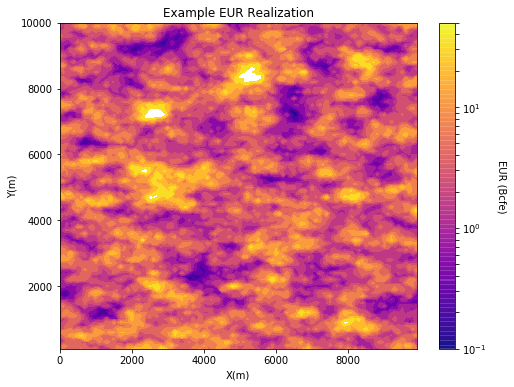

<module 'matplotlib.pyplot' from 'C:\\Users\\mpyrc\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [6]:
pixelplt(expsim,xmin,xmax,ymin,ymax,cell_size,vminexp,vmaxexp,"Example EUR Realization","X(m)","Y(m)","EUR (Bcfe)",cmap,"F2_Eg_EUR_Real")

Let's check the histogram and summary statistics of a single realization.

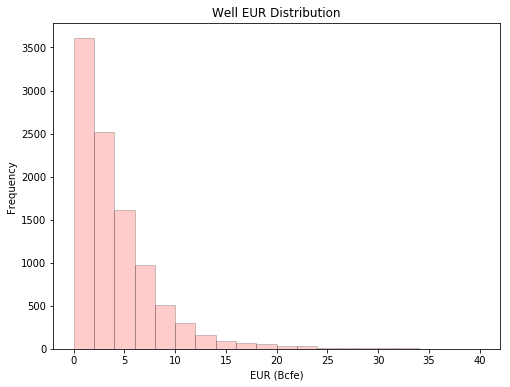

Average of ln(Well EUR) is 4.2224924066966745
Variance of ln(Well EUR) is 17.6072024728537
Standard Deviation of ln(Well EUR) is 4.196093715928387
Average of Well EUR is 4.2224924066966745
Variance of Well EUR is 17.6072024728537
Standard Deviation of Well EUR is 4.196093715928387
Standard Error of Pad Average is 1.4835431605136105
Variance Error of Pad Average is 2.2009003091067125
Variance Error of Pad Sum is 140.8576197828296


In [26]:
# This is the EUR summary statistics and histogram for Figure 1
hist(expsim.flatten(),0,40,log=False,cumul=False,bins=20,weights=None,xlabel="EUR (Bcfe)",title="Well EUR Distribution",fig_name="F1_EUR_Dist")

print('Average of ln(Well EUR) is ' + str(np.average(sim.flatten())))
print('Variance of ln(Well EUR) is ' + str(np.var(sim.flatten())))
print('Standard Deviation of ln(Well EUR) is ' + str(np.std(sim.flatten())))
print('Average of Well EUR is ' + str(np.average(expsim.flatten())))
print('Variance of Well EUR is ' + str(np.var(expsim.flatten())))
print('Standard Deviation of Well EUR is ' + str(np.std(expsim.flatten())))
print('Standard Error of Pad Average is ' + str(np.std(expsim.flatten())/np.sqrt(8)))
print('Variance Error of Pad Average is ' + str(np.var(expsim.flatten())/8))
print('Variance Error of Pad Sum is ' + str(np.var(expsim.flatten())/8*64))


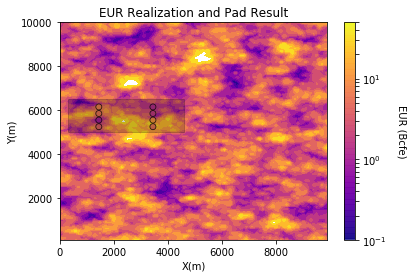

In [8]:
# This is the example realization with pad for Figure 2
pad1 = extract_pad_sample(sim,xmin,xmax,ymin,ymax,cell_size,ox=-5,oy=50,xspace=2000,yspace=300,nxwell=2,nywell=4,name='well_EUR')
pad2 = extract_pad_sample(sim,xmin,xmax,ymin,ymax,cell_size,ox=50,oy=80,xspace=2000,yspace=300,nxwell=2,nywell=4,name='well_EUR')
pad = pd.concat([pad1,pad2],axis=0)
locpix_st(expsim,xmin,xmax,ymin,ymax,cell_size,vminexp,vmaxexp,pad1,'X','Y','well_EUR','EUR Realization and Pad Result','X(m)','Y(m)','EUR (Bcfe)',cmap,fig_name='Eg_Sim_w_pad')
plt.gca().add_patch(Rectangle((300,5000.125), 4300, 1500,color='black',linewidth = 1.0,alpha=0.2,facecolor = None))
plt.savefig('F2_Eg_EUR_Real_Pad.tif',dpi=600,bbox_inches="tight")
plt.show()

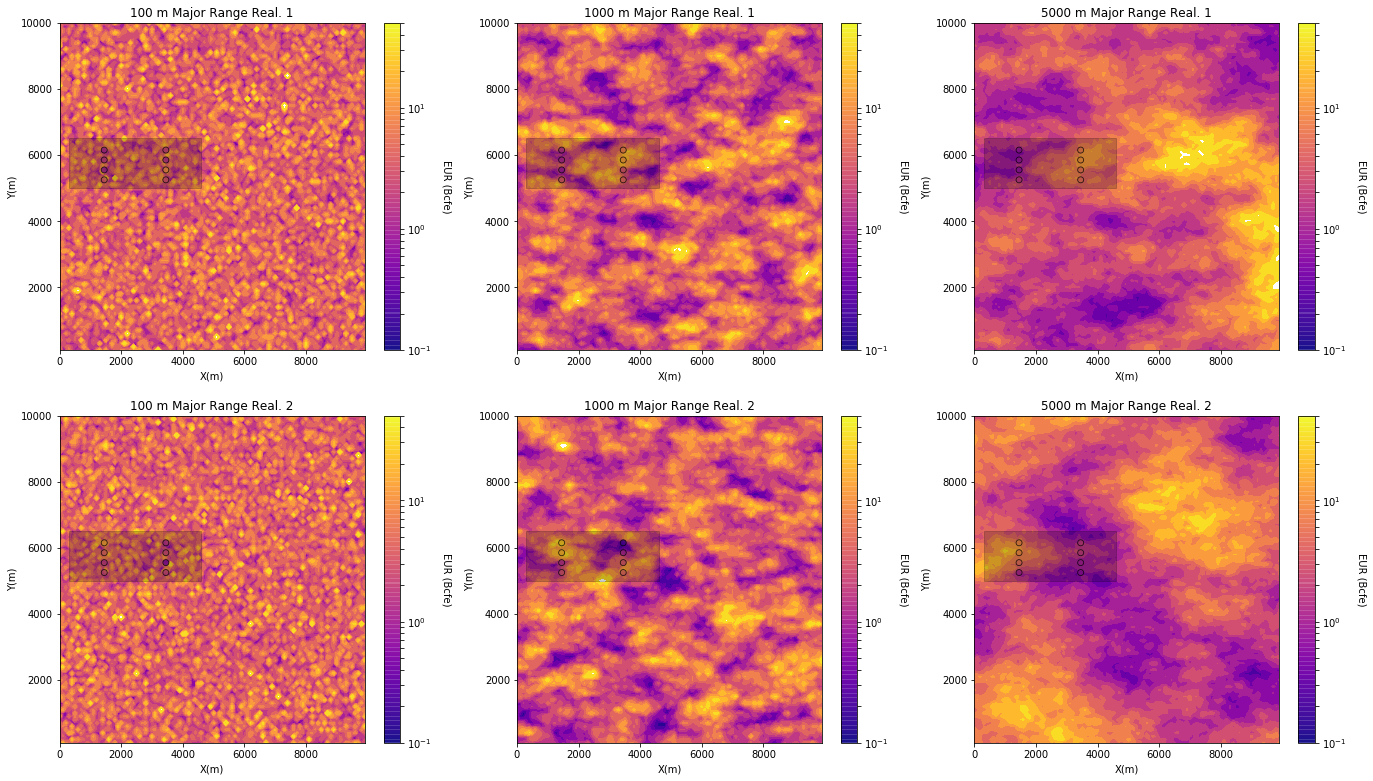

In [54]:
# This is a plot of 3 variogram ranges with 2 realizations each and pad location indicated (Figure 4 in the Paper)
plt.subplot(231)
sim,value = GSLIB_sgsim_2d_uncond(1,nx,ny,cell_size,23,100,50,azimuth,"simulation")
sim = affine(sim,mean,stdev)                                     # correct the distribution to a target mean and standard deviation.
expsim = exponentiate(sim)
pad = extract_pad_sample(expsim,xmin,xmax,ymin,ymax,cell_size,ox=-5,oy=50,xspace=2000,yspace=300,nxwell=2,nywell=4,name='well_EUR')
locpix_st(expsim,xmin,xmax,ymin,ymax,cell_size,vminexp,vmaxexp,pad,'X','Y','well_EUR','100 m Major Range Real. 1','X(m)','Y(m)','EUR (Bcfe)',cmap,fig_name='Eg_Sim_w_pad')
plt.gca().add_patch(Rectangle((300,5000.125), 4300, 1500,color='black',linewidth = 1.0,alpha=0.2,facecolor = None))

plt.subplot(232)
sim,value = GSLIB_sgsim_2d_uncond(1,nx,ny,cell_size,23,1000,500,azimuth,"simulation")
sim = affine(sim,mean,stdev)                                     # correct the distribution to a target mean and standard deviation.
expsim = exponentiate(sim)
pad = extract_pad_sample(expsim,xmin,xmax,ymin,ymax,cell_size,ox=-5,oy=50,xspace=2000,yspace=300,nxwell=2,nywell=4,name='well_EUR')
locpix_st(expsim,xmin,xmax,ymin,ymax,cell_size,vminexp,vmaxexp,pad,'X','Y','well_EUR','1000 m Major Range Real. 1','X(m)','Y(m)','EUR (Bcfe)',cmap,fig_name='Eg_Sim_w_pad')
plt.gca().add_patch(Rectangle((300,5000.125), 4300, 1500,color='black',linewidth = 1.0,alpha=0.2,facecolor = None))

plt.subplot(233)
sim,value = GSLIB_sgsim_2d_uncond(1,nx,ny,cell_size,23,5000,2500,azimuth,"simulation")
sim = affine(sim,mean,stdev)                                     # correct the distribution to a target mean and standard deviation.
expsim = exponentiate(sim)
pad = extract_pad_sample(expsim,xmin,xmax,ymin,ymax,cell_size,ox=-5,oy=50,xspace=2000,yspace=300,nxwell=2,nywell=4,name='well_EUR')
locpix_st(expsim,xmin,xmax,ymin,ymax,cell_size,vminexp,vmaxexp,pad,'X','Y','well_EUR','5000 m Major Range Real. 1','X(m)','Y(m)','EUR (Bcfe)',cmap,fig_name='Eg_Sim_w_pad')
plt.gca().add_patch(Rectangle((300,5000.125), 4300, 1500,color='black',linewidth = 1.0,alpha=0.2,facecolor = None))

plt.subplot(234)
sim,value = GSLIB_sgsim_2d_uncond(1,nx,ny,cell_size,24,100,50,azimuth,"simulation")
sim = affine(sim,mean,stdev)                                     # correct the distribution to a target mean and standard deviation.
expsim = exponentiate(sim)
pad = extract_pad_sample(expsim,xmin,xmax,ymin,ymax,cell_size,ox=-5,oy=50,xspace=2000,yspace=300,nxwell=2,nywell=4,name='well_EUR')
locpix_st(expsim,xmin,xmax,ymin,ymax,cell_size,vminexp,vmaxexp,pad,'X','Y','well_EUR','100 m Major Range Real. 2','X(m)','Y(m)','EUR (Bcfe)',cmap,fig_name='Eg_Sim_w_pad')
plt.gca().add_patch(Rectangle((300,5000.125), 4300, 1500,color='black',linewidth = 1.0,alpha=0.2,facecolor = None))

plt.subplot(235)
sim,value = GSLIB_sgsim_2d_uncond(1,nx,ny,cell_size,24,1000,500,azimuth,"simulation")
sim = affine(sim,mean,stdev)                                     # correct the distribution to a target mean and standard deviation.
expsim = exponentiate(sim)
pad = extract_pad_sample(expsim,xmin,xmax,ymin,ymax,cell_size,ox=-5,oy=50,xspace=2000,yspace=300,nxwell=2,nywell=4,name='well_EUR')
locpix_st(expsim,xmin,xmax,ymin,ymax,cell_size,vminexp,vmaxexp,pad,'X','Y','well_EUR','1000 m Major Range Real. 2','X(m)','Y(m)','EUR (Bcfe)',cmap,fig_name='Eg_Sim_w_pad')
plt.gca().add_patch(Rectangle((300,5000.125), 4300, 1500,color='black',linewidth = 1.0,alpha=0.2,facecolor = None))

plt.subplot(236)
sim,value = GSLIB_sgsim_2d_uncond(1,nx,ny,cell_size,25,5000,2500,azimuth,"simulation")
sim = affine(sim,mean,stdev)                                     # correct the distribution to a target mean and standard deviation.
expsim = exponentiate(sim)
pad = extract_pad_sample(expsim,xmin,xmax,ymin,ymax,cell_size,ox=-5,oy=50,xspace=2000,yspace=300,nxwell=2,nywell=4,name='well_EUR')
locpix_st(expsim,xmin,xmax,ymin,ymax,cell_size,vminexp,vmaxexp,pad,'X','Y','well_EUR','5000 m Major Range Real. 2','X(m)','Y(m)','EUR (Bcfe)',cmap,fig_name='Eg_Sim_w_pad')
plt.gca().add_patch(Rectangle((300,5000.125), 4300, 1500,color='black',linewidth = 1.0,alpha=0.2,facecolor = None))

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=2.5, wspace=0.2, hspace=0.2)
plt.savefig('F4_Eg_EUR_Real_Pad.tif',dpi=300,bbox_inches="tight")
plt.show()

In [9]:
# The experiment - condensed, simplified
load = True               # if already run, then True to load the file instead

nreal = 10000             # number of realizations to consider
nwell = 8                 # number of wells in the template

rmaxset = np.array([100,500,1000,2500,5000])   # ranges in the major direction to consider

seed_init = 7307307

pad1ox = -5               # use the same location in each realization, they are unconditional so location doesn't matter
pad1oy = 50

azi = 90

if load == True:
    df_sum = pd.read_csv('summary_v2.csv')
    print('Early exit, since data loaded instead of recreated')
    print(df_sum[:10])
    print('Ignore this error.')
    raise KeyboardInterrupt   # ignore this error



nsum = 0
for rmax in np.nditer(rmaxset):
    for ireal in range(0,nreal):
        nsum = nsum + 1

summary_result = np.zeros([18,nsum])
cond_result = np.zeros([18,len(rmaxset)])

iresults_row = 0
isum = 0
irange = 0
for rmax in np.nditer(rmaxset):
    print('Running Rmax: ' + str(rmax))
    rmin = rmax * 0.5
    for ireal in range(0,nreal):
        seed = seed_init+ireal+nreal*irange 
        sim,value = GSLIB_sgsim_2d_uncond(1,nx,ny,cell_size,seed,rmax,rmin,azimuth,"simulation")
        sim = affine(sim,mean,stdev)
        expsim = np.exp(sim)
        #print('Running Rmax: ' + str(rmax) + ', Realization #' + str(ireal))
 
        sim_average = np.average(expsim.flatten())
        sim_var = np.var(expsim.flatten())
        pad1 = extract_pad_sample(expsim,xmin,xmax,ymin,ymax,cell_size,ox=pad1ox,oy=pad1oy,xspace=2000,yspace=300,nxwell=2,nywell=4,name='well_EUR')
        summary_result[0,isum] = 0
        summary_result[1,isum] = 0
        summary_result[2,isum] = 0
        summary_result[3,isum] = pad1['well_EUR'].mean()
        summary_result[4,isum] = pad1['well_EUR'].mean()*pad1['well_EUR'].mean()
        summary_result[5,isum] = pad1['well_EUR'].sum()
        summary_result[6,isum] = pad1['well_EUR'].sum()*pad1['well_EUR'].sum()
        summary_result[7,isum] = pad1.iloc[0:1,2].mean()
        summary_result[8,isum] = pad1.iloc[0:2,2].mean()
        summary_result[9,isum] = pad1.iloc[0:3,2].mean()
        summary_result[10,isum] = pad1.iloc[0:4,2].mean()
        summary_result[11,isum] = pad1.iloc[0:5,2].mean()
        summary_result[12,isum] = rmax
        summary_result[13,isum] = rmin
        summary_result[14,isum] = azi 
        summary_result[15,isum] = pad1['well_EUR'].var()
        summary_result[16,isum] = sim_average
        summary_result[17,isum] = sim_var           
        isum = isum + 1
        irange = irange + 1  
    
# build dataframes and write out experiment
ty = summary_result[0,:]
dx = summary_result[1,:]
dy = summary_result[2,:]
pm = summary_result[3,:]
pmsq = summary_result[4,:]
ps = summary_result[5,:]
pssq = summary_result[6,:]
firw = summary_result[7,:]
secw = summary_result[8,:]
thiw = summary_result[9,:]
fouw = summary_result[10,:]
fifw = summary_result[11,:]
rmaj = summary_result[12,:]
rmin = summary_result[13,:]
azi = summary_result[14,:]
var = summary_result[15,:]
savg = summary_result[16,:]
svar = summary_result[17,:]
df_sum = pd.DataFrame({'type': ty, 'dx': dx, 'dy': dy,'pad_mean': pm,'pad_mean_sq': pmsq,'pad_sum': ps,'pad_sum_sq': pssq,'1well_avg': firw,'2well_avg': secw,'3well_avg': thiw,'4well_avg': fouw,'5well_avg': fifw,'rmaj': rmaj,'rmin': rmin,'azi': azi,'pad_var' : var,'sim_avg' : savg,'sim_var' : svar})
df_sum.to_csv("summary_v2.csv")    

# build dataframes and write out experiment
ty = summary_result[0,:]
dx = summary_result[1,:]
dy = summary_result[2,:]
pm = summary_result[3,:]
ps = summary_result[4,:]
firw = summary_result[5,:]
secw = summary_result[6,:]
thiw = summary_result[7,:]
fouw = summary_result[8,:]
fifw = summary_result[9,:]
rmaj = summary_result[10,:]
rmin = summary_result[11,:]
azi = summary_result[12,:]
df_sum = pd.DataFrame({'type': ty, 'dx': dx, 'dy': dy,'pad_mean': pm,'pad_sum': ps,'1well_avg': firw,'2well_avg': secw,'3well_avg': thiw,'4well_avg': fouw,'5well_avg': fifw,'rmaj': rmaj,'rmin': rmin,'azi': azi})
df_sum.to_csv("summary.csv")



Early exit, since data loaded instead of recreated
   Unnamed: 0  type  dx  dy  pad_mean  pad_mean_sq    pad_sum   pad_sum_sq  \
0           0     0   0   0  3.472476    12.058088  27.779806   771.717627   
1           1     0   0   0  3.810555    14.520330  30.484440   929.301101   
2           2     0   0   0  5.848308    34.202709  46.786466  2188.973383   
3           3     0   0   0  5.461763    29.830855  43.694104  1909.174733   
4           4     0   0   0  5.479827    30.028506  43.838617  1921.824385   
5           5     0   0   0  4.800409    23.043930  38.403275  1474.811512   
6           6     0   0   0  4.866935    23.687054  38.935478  1515.971455   
7           7     0   0   0  9.346988    87.366176  74.775900  5591.435255   
8           8     0   0   0  6.540849    42.782701  52.326789  2738.092853   
9           9     0   0   0  3.939632    15.520697  31.517052   993.324580   

   1well_avg  2well_avg  3well_avg  4well_avg  5well_avg  rmaj  rmin  azi  \
0   1.554822 

KeyboardInterrupt: 

In the following fields we calculate the conditional statistics and sumary plots used in the paper.

In [8]:
# Question 1: the variance within pad conditional to spatial continuity (second plot is Figure 5)

# Let's look at the variance distribution for all variogram ranges
hist(df_sum['pad_var'],0,500,log=False,cumul=False,bins=20,weights=None,xlabel="EUR (Bcfe)",title="Pad EUR (Bcfe) Variance",fig_name="3a_Pad_Sum_Dist")

pad_var = df_sum['pad_var']
pad_var.describe()

# Let's break the DataFrame up by major range cases
df100 = df_sum.loc[df_sum['rmaj'] == 100]
df500 = df_sum.loc[df_sum['rmaj'] == 500]
df1000 = df_sum.loc[df_sum['rmaj'] == 1000]
df2500 = df_sum.loc[df_sum['rmaj'] == 2500]
df5000 = df_sum.loc[df_sum['rmaj'] == 5000]

# Let's calculate the summary statistics for each
#quantile_100 = df100.quantile(0.5,axis = (0,20),numeric_only = True)
#quantile_100

expectation_in_pad = df_sum.groupby('rmaj')['pad_var'].mean()
P10_in_pad = df_sum.groupby('rmaj')['pad_var'].quantile(.9)
P90_in_pad = df_sum.groupby('rmaj')['pad_var'].quantile(.1)

plt.plot(rmaxset,expectation_in_pad,color='black')
plt.plot(rmaxset,P10_in_pad,'r--',color='black',linewidth = 1.0)
plt.plot(rmaxset,P90_in_pad,'r--',color='black',linewidth = 1.0)
plt.xlabel('Spatial Continuity major Range (m)')
plt.ylabel('Well EUR Variance within Pad ($Bcfe^2$)')
plt.title('Within Well Pad Well Estimated Ultimate Recovery (EUR) Variance')
plt.ylim(0,80)
plt.xlim(0,5000)
plt.text(60, 5, 'P10')
plt.text(60, 37, 'Expectation')
plt.text(60, 75, 'P90')

plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.2, hspace=0.2)
plt.savefig('F5_Within_Pad.tif',dpi=600,bbox_inches="tight")
plt.show()


NameError: name 'df_sum' is not defined

In [64]:
df_sum.describe()

,Unnamed: 0,type,dx,dy,pad_mean,pad_mean_sq,pad_sum,pad_sum_sq,1well_avg,2well_avg,3well_avg,4well_avg,5well_avg,rmaj,rmin,azi,pad_var,sim_avg,sim_var
count,50000.000000,50000.0,50000.0,50000.0,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.0,50000.000000,50000.000000,50000.000000
mean,24999.500000,0.0,0.0,0.0,4.461545,26.863931,35.692359,1719.291585,4.459375,4.458169,4.452006,4.455070,4.456669,1820.000000,910.000000,90.0,29.064551,4.474413,33.294679
std,14433.901067,0.0,0.0,0.0,2.637932,44.995978,21.103459,2879.742621,5.523497,4.076602,3.587476,3.269110,3.064878,1785.962988,892.981494,0.0,101.117063,0.106137,9.805928
min,0.000000,0.0,0.0,0.0,0.325798,0.106144,2.606381,6.793221,0.037834,0.138975,0.175347,0.223910,0.236381,100.000000,50.000000,90.0,0.004467,3.938293,9.615874
25%,12499.750000,0.0,0.0,0.0,2.747580,7.549194,21.980638,483.148428,1.377608,1.951311,2.171110,2.350108,2.472676,500.000000,250.000000,90.0,3.451305,4.437284,28.948729
50%,24999.500000,0.0,0.0,0.0,3.898675,15.199668,31.189401,972.778758,2.726594,3.286830,3.478374,3.623922,3.704679,1000.000000,500.000000,90.0,9.482044,4.475564,32.732238
75%,37499.250000,0.0,0.0,0.0,5.486267,30.099127,43.890137,1926.344114,5.383485,5.558545,5.559983,5.569090,5.543989,2500.000000,1250.000000,90.0,24.945816,4.507748,36.160221
max,49999.000000,0.0,0.0,0.0,44.917690,2017.598852,359.341518,129126.326500,97.037578,104.397371,72.850766,68.622051,55.079165,5000.000000,2500.000000,90.0,8125.101482,5.679532,386.919189


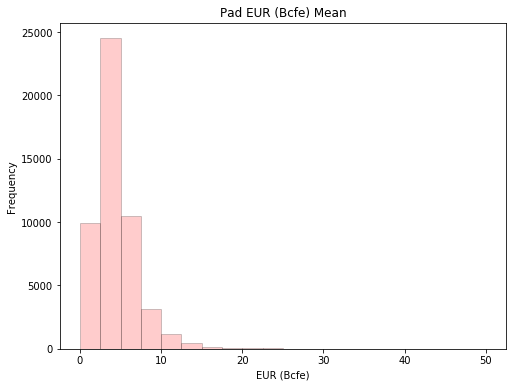

In [14]:
# Check the distribution of pad means
hist(df_sum['pad_mean'],0,50,log=False,cumul=False,bins=20,weights=None,xlabel="EUR (Bcfe)",title="Pad EUR (Bcfe) Mean",fig_name="3a_Pad_Sum_Dist")


In [7]:
# Let's check the variation within pads by local pad average and variogram major range - Figure 6

bins = [0,10,20,30]
labels = [5,15,25]

df_sum = df_sum
df_sum['pad_mean_bins'] = pd.cut(df_sum['pad_mean'], bins=bins,labels=labels)
df_sum.head()

dfpad5 = df_sum.loc[df_sum['pad_mean_bins'] == 5]
dfpad15 = df_sum.loc[df_sum['pad_mean_bins'] == 15]
dfpad25 = df_sum.loc[df_sum['pad_mean_bins'] == 25]

pad5 = dfpad5.groupby('rmaj')['pad_var'].mean()
pad15 = dfpad15.groupby('rmaj')['pad_var'].mean()
pad25 = dfpad25.groupby('rmaj')['pad_var'].mean()

plt.plot(rmaxset,pad5,color='black')
plt.plot(rmaxset,pad15,color='black',linewidth = 1.0)
plt.plot(rmaxset,pad25,color='black',linewidth = 1.0)
plt.xlabel('Spatial Continuity Major Range (m)')
plt.ylabel('Well EUR Variance within Pad ($Bcfe^2$)')
plt.title('Within Well Pad Well Estimated Ultimate Recovery (EUR) Variance')
plt.ylim(1,9000)
plt.yscale('log')
plt.xlim(0,5000)
plt.text(60, 40, '0-10 Bcfe Pad Average')
plt.text(60, 500, '10-20 Bcfe Pad Average')
plt.text(60, 5000, '20-30 Bcfe Pad Average')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.2, hspace=0.2)
plt.savefig('F6_EUR_within_pad_by_pad_average.tif',dpi=600,bbox_inches="tight")
plt.show()


NameError: name 'df_sum' is not defined

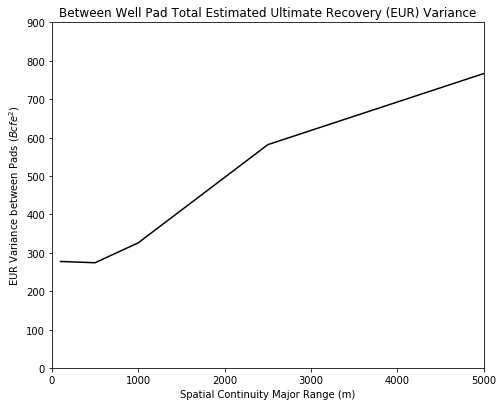

In [61]:
# Question 2 - Now Calculate the Between Well Pad Variance in EUR from Figure 7

between_pad_var = df_sum.groupby('rmaj')['pad_sum'].var()
plt.plot(rmaxset,between_pad_var,color='black')
plt.xlabel('Spatial Continuity Major Range (m)')
plt.ylabel('EUR Variance between Pads ($Bcfe^2$)')
plt.title('Between Well Pad Total Estimated Ultimate Recovery (EUR) Variance')
plt.ylim(1,900)
plt.yscale('linear')
plt.xlim(0,5000)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.2, hspace=0.2)
plt.savefig('F7_EUR_between_pad.tif',dpi=600,bbox_inches="tight")
plt.show()

In [6]:
# Question 3: the variance within pad conditional to spatial continuity (second plot is Figure 9)

# Let's make first well EUR bins
bins = [0,1,2,3,4,5,6]
labels = [0.5,1.5,2.5,3.5,4.5,5.5]

df_sum['1well_avg_bins'] = pd.cut(df_sum['1well_avg'], bins=bins,labels=labels)
df_sum.head()

# Let's break the DataFrame up by major range cases
df100 = df_sum.loc[df_sum['rmaj'] == 100]
df500 = df_sum.loc[df_sum['rmaj'] == 500]
df1000 = df_sum.loc[df_sum['rmaj'] == 1000]
df2500 = df_sum.loc[df_sum['rmaj'] == 2500]
df5000 = df_sum.loc[df_sum['rmaj'] == 5000]

# Let's get the conditional expectation for each range for each 1st well EUR bin
padsum100 = df100.groupby('1well_avg_bins')['pad_sum'].mean()
padsum500 = df500.groupby('1well_avg_bins')['pad_sum'].mean()
padsum1000 = df1000.groupby('1well_avg_bins')['pad_sum'].mean()
padsum2500 = df2500.groupby('1well_avg_bins')['pad_sum'].mean()
padsum5000 = df5000.groupby('1well_avg_bins')['pad_sum'].mean()

global_pad_mean = [35.7,35.7,35.7,35.7,35.7,35.7]

plt.figure(figsize=(8,6))
plt.plot(labels,padsum100,color='blue')
plt.plot(labels,padsum500,color='green')
plt.plot(labels,padsum1000,color='orange')
plt.plot(labels,padsum2500,color='red')
plt.plot(labels,padsum5000,color='black')
plt.plot(labels,global_pad_mean,color='black',dashes=[5, 5, 5, 5])

plt.xlabel('Well EUR of the First Well (Bcfe)')
plt.ylabel('Well EUR Variance within Pad ($Bcfe^2$)')
plt.title('Within Well Pad Well Estimated Ultimate Recovery (EUR) Variance')
plt.ylim(0,60)
plt.xlim(0,6)
plt.text(0.05, 15, '100 m')
plt.text(0.05, 22, '500 m')
plt.text(0.05, 27, '1000 m')
plt.text(0.05, 31, '2500 m')
plt.text(0.05, 34, '5000 m')
plt.text(1.15, 37, 'Pad Expected Production')
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.2, hspace=0.2)
plt.savefig('F8_Decision_Criteria.tif',dpi=600,bbox_inches="tight")
plt.show()


NameError: name 'df_sum' is not defined

Mean of pad total production = 35.69235944542719
Variance of pad total production = 445.3559692141772


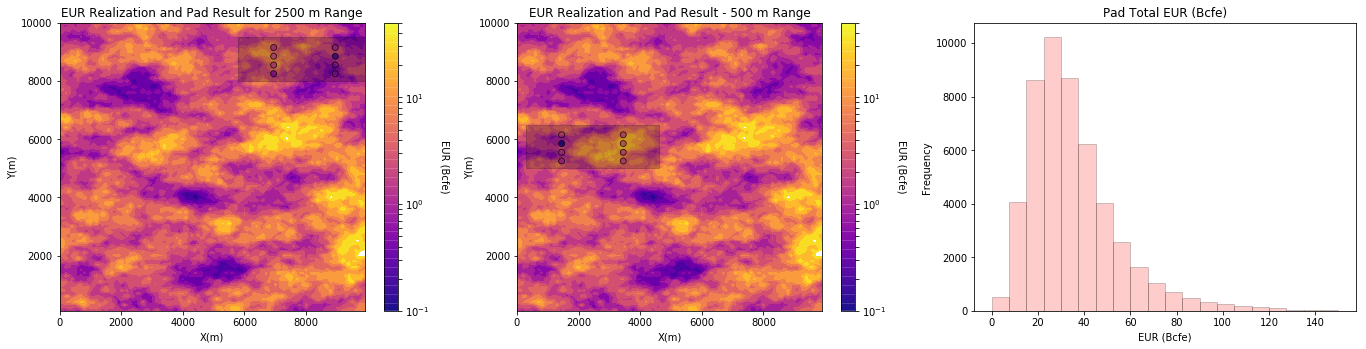

In [12]:
import geostatspy.GSLIB as GSLIB
plt.subplot(133)
GSLIB.hist_st(df_sum['pad_sum'],0,150,log=False,cumul=False,bins=20,weights=None,xlabel="EUR (Bcfe)",title="Pad Total EUR (Bcfe)")
print('Mean of pad total production = ' + str(df_sum['pad_sum'].mean()))
print('Variance of pad total production = ' + str(df_sum['pad_sum'].var()))

sima,value = GSLIB_sgsim_2d_uncond(1,nx,ny,cell_size,23,2500,1250,azimuth,"simulation")
sima = affine(sima,mean,stdev)
expsima = np.exp(sima)
        
simb,value = GSLIB_sgsim_2d_uncond(1,nx,ny,cell_size,23,2500,1250,azimuth,"simulation")
simb = affine(simb,mean,stdev)
expsimb = np.exp(simb)

plt.subplot(132)
pad1 = extract_pad_sample(sima,xmin,xmax,ymin,ymax,cell_size,ox=-5,oy=50,xspace=2000,yspace=300,nxwell=2,nywell=4,name='well_EUR')
#pad = pd.concat([pad1,pad2],axis=0)
locpix_st(expsima,xmin,xmax,ymin,ymax,cell_size,0.1,vmaxexp,pad1,'X','Y','well_EUR','EUR Realization and Pad Result - 500 m Range','X(m)','Y(m)','EUR (Bcfe)',cmap,fig_name='Eg_Sim_w_pad')
plt.gca().add_patch(Rectangle((300,5000.125), 4300, 1500,color='black',linewidth = 1.0,alpha=0.2,facecolor = None))

plt.subplot(131)
pad2 = extract_pad_sample(simb,xmin,xmax,ymin,ymax,cell_size,ox=50,oy=80,xspace=2000,yspace=300,nxwell=2,nywell=4,name='well_EUR')
#pad = pd.concat([pad1,pad2],axis=0)
locpix_st(expsimb,xmin,xmax,ymin,ymax,cell_size,0.1,vmaxexp,pad2,'X','Y','well_EUR','EUR Realization and Pad Result for 2500 m Range','X(m)','Y(m)','EUR (Bcfe)',cmap,fig_name='Eg_Sim_w_pad')
plt.gca().add_patch(Rectangle((5800,8000.125), 4300, 1500,color='black',linewidth = 1.0,alpha=0.2,facecolor = None))


plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1., wspace=0.2, hspace=0.2)
plt.savefig('F3_Eg_Pad.tif',dpi=600,bbox_inches="tight")
plt.show()



Of course there is so much that may be done with model resampling methods. I hope you found this tutorial useful. I'm always happy to discuss geostatistics, statistical modeling, uncertainty modeling and machine learning,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
On twitter I'm the @GeostatsGuy.
